Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from skimage.transform import pyramid_reduce, resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D

In [ ]:
#path to the dataset
Path='/content/drive/MyDrive/Lungs_CT_Covid19_Detect/data_set'

In [ ]:
#setting image parameters for the Image Data Generator
image_height=248
image_width=248
batch=64

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.15,
    brightness_range = [.1,.2],
    validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    Path,
    target_size=(image_height, image_width),
    batch_size=batch,
    class_mode='binary',
    color_mode="rgb",
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    Path, 
    target_size=(image_height, image_width),
    batch_size=batch,
    class_mode='binary',
    color_mode="rgb",
    subset='validation')


Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
#callback option
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

## Normal VGG16


In [ ]:
base_VGG16 =VGG16(input_shape=(248, 248,3), include_top=False)
base_VGG16 = Sequential()
base_VGG16.add(VGG16(include_top=False, pooling='max'))
base_VGG16.add(Dense(1, activation='sigmoid'))
base_VGG16.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC(
        num_thresholds=200, curve='ROC',
        summation_method='interpolation', name=None, dtype=None,
        thresholds=None, multi_label=False, label_weights=None
    ),'accuracy'])
base_VGG16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_base_VGG16=base_VGG16.fit_generator(train_generator ,steps_per_epoch = train_generator.samples // batch,
                                            validation_data = validation_generator, validation_steps = validation_generator.samples // batch, 
                                            epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
9/9 [==============================] - 133s 16s/step - loss: 0.6923 - recall: 0.2401 - precision: 0.5076 - auc: 0.5427 - accuracy: 0.4813 - val_loss: 0.7137 - val_recall: 0.2794 - val_precision: 0.4634 - val_auc: 0.4249 - val_accuracy: 0.4453
Epoch 2/100
9/9 [==============================] - 19s 2s/step - loss: 0.6847 - recall: 0.3871 - precision: 0.5967 - auc: 0.5959 - accuracy: 0.5431 - val_loss: 0.7052 - val_recall: 0.2899 - val_precision: 0.4545 - val_auc: 0.4810 - val_accuracy: 0.4297
Epoch 3/100
9/9 [==============================] - 19s 2s/step - loss: 0.6859 - recall: 0.5267 - precision: 0.5944 - auc: 0.5786 - accuracy: 0.5618 - val_loss: 0.6974 - val_recall: 0.4203 - val_precision: 0.5800 - val_auc: 0.5305 - val_accuracy: 0.5234
Epoch 4/100
9/9 [==============================] - 19s 2s/step - loss: 0.6817 - recall: 0.5836 - precision: 0.5705 - auc: 0.5893 - accuracy: 0.5469 - val_loss: 0.6949 - val_recall: 0.5735 - val_precision: 0.5652 - val_auc: 0.4989 - val_acc

In [ ]:
base_VGG16.evaluate(validation_generator, verbose = 1)

3/3 [==============================] - 6s 2s/step - loss: 0.7849 - recall: 0.6203 - precision: 0.5213 - auc: 0.5107 - accuracy: 0.4932


[0.7849180102348328,
 0.6202531456947327,
 0.521276593208313,
 0.5107319951057434,
 0.4932432472705841]

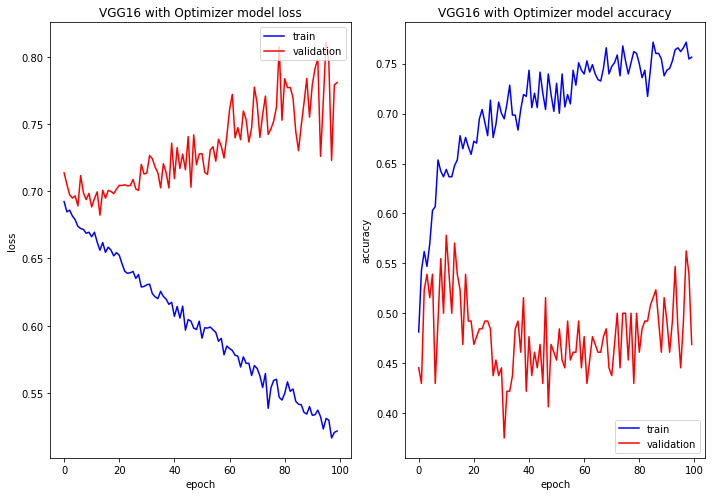

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('VGG16 with Optimizer model loss')
ax[0].plot(history_base_VGG16.history['loss'], 'b')
ax[0].plot(history_base_VGG16.history['val_loss'], 'r')
ax[0].legend(['train', 'validation'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('VGG16 with Optimizer model accuracy')
ax[1].plot(history_base_VGG16.history['accuracy'], 'b')
ax[1].plot(history_base_VGG16.history['val_accuracy'], 'r')
ax[1].legend(['train', 'validation'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## Pre-Trained VGG

In [ ]:
base_model = VGG16(input_shape = (248, 248, 3), 
include_top = False, 
weights = 'imagenet',
pooling='max')
for layer in base_model.layers[:-3]:
    layer.trainable = False
# add output layer 
VGG16_Pretrained=Sequential()
VGG16_Pretrained.add(base_model)
VGG16_Pretrained.add(Flatten())
VGG16_Pretrained.add(Dense(248, activation='relu'))
VGG16_Pretrained.add(Dropout(0.5))
VGG16_Pretrained.add(Dense(1, activation='sigmoid'))


VGG16_Pretrained.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001), loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC(
           num_thresholds=200, curve='ROC',
            summation_method='interpolation', name=None, dtype=None,
            thresholds=None, multi_label=False, label_weights=None
        ),'accuracy'])

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 248, 248, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 248, 248, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 248, 248, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 124, 124, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 124, 124, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 124, 124, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

In [ ]:
VGG16_Pretrained.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 248)               127224    
_________________________________________________________________
dropout (Dropout)            (None, 248)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 249       
Total params: 14,842,161
Trainable params: 2,487,281
Non-trainable params: 12,354,880
_________________________________________________________________


In [ ]:
# load images in RGB and with no normalisation
train_datagen_pretrained = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    validation_split=0.20) 

train_generator_pretrained = train_datagen_pretrained.flow_from_directory(
    Path,
    target_size=(image_height, image_width),
    batch_size=batch,
    class_mode='binary',
    color_mode="rgb",
    subset='training') 

validation_generator_pretrained = train_datagen_pretrained.flow_from_directory(
    Path, 
    target_size=(image_height, image_width),
    batch_size=batch,
    class_mode='binary',
    color_mode="rgb",
    subset='validation') 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
history_vgg_pretrained = VGG16_Pretrained.fit_generator(train_generator_pretrained, steps_per_epoch = train_generator_pretrained.samples // batch,
        validation_data = validation_generator_pretrained, validation_steps = validation_generator_pretrained.samples // batch,
        epochs=100,callbacks=early)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
9/9 [==============================] - 19s 2s/step - loss: 0.9911 - recall_1: 0.2325 - precision_1: 0.6010 - auc_1: 0.5196 - accuracy: 0.4789 - val_loss: 0.8362 - val_recall_1: 0.0429 - val_precision_1: 0.7500 - val_auc_1: 0.4163 - val_accuracy: 0.4688
Epoch 2/100
9/9 [==============================] - 16s 2s/step - loss: 0.9638 - recall_1: 0.2562 - precision_1: 0.4782 - auc_1: 0.5169 - accuracy: 0.4616 - val_loss: 0.8027 - val_recall_1: 0.1000 - val_precision_1: 0.5385 - val_auc_1: 0.4273 - val_accuracy: 0.4609
Epoch 3/100
9/9 [==============================] - 15s 2s/step - loss: 0.9302 - recall_1: 0.2928 - precision_1: 0.5699 - auc_1: 0.5195 - accuracy: 0.4841 - val_loss: 0.7678 - val_recall_1: 0.1304 - val_precision_1: 0.5294 - val_auc_1: 0.4634 - val_accuracy: 0.4688
Epoch 4/100
9/9 [==============================] - 16s 2s/step - loss: 0.8208 - recall_1: 0.4436 - precision_1: 0.6003 - auc_1: 0.5560 - accuracy: 0.5497 - val_loss: 0.7476 - val_recall_1: 0.1515 - val_pre

In [ ]:
VGG16_Pretrained.evaluate_generator(validation_generator_pretrained, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3/3 [==============================] - 8s 3s/step - loss: 0.6086 - recall_2: 0.9494 - precision_2: 0.6198 - auc_2: 0.7669 - accuracy: 0.6622


[0.6085969805717468,
 0.949367105960846,
 0.6198347210884094,
 0.7669234871864319,
 0.662162184715271]

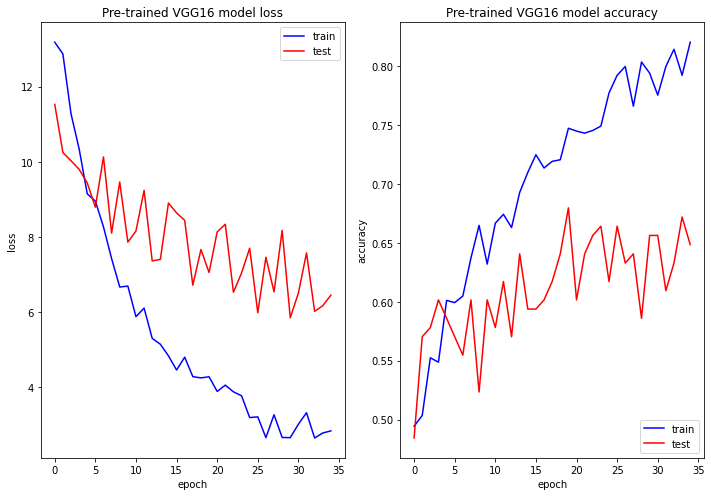

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('Pre-trained VGG16 model loss')
ax[0].plot(history_vgg_pretrained.history['loss'], 'b')
ax[0].plot(history_vgg_pretrained.history['val_loss'], 'r')
ax[0].legend(['train', 'validation'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('Pre-trained VGG16 model accuracy')
ax[1].plot(history_vgg_pretrained.history['accuracy'], 'b')
ax[1].plot(history_vgg_pretrained.history['val_accuracy'], 'r')
ax[1].legend(['train', 'validation'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## MobileNet Pre-trained


In [ ]:
from keras.applications import MobileNet


In [ ]:
MobileNet=MobileNet(input_shape = (248, 248, 3),weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=MobileNet.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation

model_mobileNet_pretrained = tf.keras.models.Model(MobileNet.input, outputs=preds)
opt = SGD(lr=1e-5)
model_mobileNet_pretrained.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC(
        num_thresholds=200, curve='ROC',
        summation_method='interpolation', name=None, dtype=None,
        thresholds=None, multi_label=False, label_weights=None
    ),'accuracy'])

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model_mobileNet_pretrained.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

In [ ]:
#history_mobileNet_pretrained=model_mobileNet_pretrained.fit(train_generator_pretrained, epochs=30)
history_mobileNet_pretrained = model_mobileNet_pretrained.fit(train_generator_pretrained, steps_per_epoch = train_generator_pretrained.samples // batch,
        validation_data = validation_generator_pretrained, validation_steps = validation_generator_pretrained.samples // batch,
        epochs=1)

Epoch 1/100
9/9 [==============================] - 19s 2s/step - loss: 0.6948 - accuracy: 0.5388 - recall: 0.9078 - precision: 0.5487 - val_loss: 0.7264 - val_accuracy: 0.5312 - val_recall: 1.0000 - val_precision: 0.5312
Epoch 2/100
9/9 [==============================] - 14s 2s/step - loss: 0.7004 - accuracy: 0.5305 - recall: 0.9346 - precision: 0.5399 - val_loss: 0.7284 - val_accuracy: 0.5234 - val_recall: 1.0000 - val_precision: 0.5234
Epoch 3/100
9/9 [==============================] - 14s 2s/step - loss: 0.7088 - accuracy: 0.5153 - recall: 0.9121 - precision: 0.5169 - val_loss: 0.7430 - val_accuracy: 0.5312 - val_recall: 1.0000 - val_precision: 0.5312
Epoch 4/100
9/9 [==============================] - 15s 2s/step - loss: 0.7064 - accuracy: 0.5295 - recall: 0.9341 - precision: 0.5358 - val_loss: 0.7489 - val_accuracy: 0.5156 - val_recall: 1.0000 - val_precision: 0.5156
Epoch 5/100
9/9 [==============================] - 14s 2s/step - loss: 0.7263 - accuracy: 0.4675 - recall: 0.9026 - 

In [ ]:
model_mobileNet_pretrained.evaluate_generator(validation_generator_pretrained, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3/3 [==============================] - 4s 731ms/step - loss: 0.6844 - recall_13: 0.8146 - precision_13: 0.5519 - auc_13: 0.5566 - accuracy: 0.5350


[0.6838685870170593,
 0.8227847814559937,
 0.5371900796890259,
 0.5729223489761353,
 0.5270270109176636]

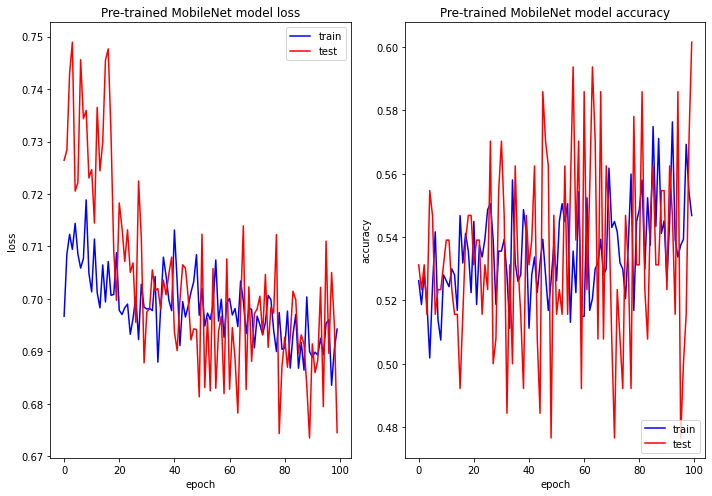

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('Pre-trained MobileNet model loss')
ax[0].plot(history_mobileNet_pretrained.history['loss'], 'b')
ax[0].plot(history_mobileNet_pretrained.history['val_loss'], 'r')
ax[0].legend(['train', 'validation'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('Pre-trained MobileNet model accuracy')
ax[1].plot(history_mobileNet_pretrained.history['accuracy'], 'b')
ax[1].plot(history_mobileNet_pretrained.history['val_accuracy'], 'r')
ax[1].legend(['train', 'validation'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## Classification on Segmented Images


In [ ]:
COVID_Seg=np.load('/content/drive/MyDrive/Lungs_CT_Covid19_Detect/Segmentation Array/COVID_Seg/COVID_Seg.npy')
NonCOVID_Seg=np.load('/content/drive/MyDrive/Lungs_CT_Covid19_Detect/Segmentation Array/NonCOVID_Seg/NonCOVID_Seg.npy')

In [ ]:
positive=[]
negative=[]

for i in range(len(COVID_Seg)):
  positive.append(COVID_Seg[i])
for i in range(len(NonCOVID_Seg)):
  negative.append(NonCOVID_Seg[i])
  

In [ ]:
x_data = positive+negative
y_data = [1]*len(positive) + [0]*len(negative)
x_data = np.array(x_data, dtype='float32')
y_data = np.array(y_data, dtype='float32')

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

In [ ]:
Segmentation_VGG16 = Sequential()
Segmentation_VGG16.add(Conv2D(input_shape=(128,128,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
Segmentation_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Segmentation_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Segmentation_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Segmentation_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Segmentation_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
Segmentation_VGG16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
Segmentation_VGG16.add(Flatten())
Segmentation_VGG16.add(Dense(units=4096,activation="relu"))
Segmentation_VGG16.add(Dense(units=4096,activation="relu"))
Segmentation_VGG16.add(Dense(units=1, activation="sigmoid"))

opt = SGD(lr=1e-5)
Segmentation_VGG16.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, label_weights=None
),'accuracy'])

In [ ]:
Segmentation_VGG16.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)      

In [ ]:
history_vgg_seg=Segmentation_VGG16.fit(x_train, y_train, validation_data=(x_val, y_val), 
                                    epochs=100, batch_size=batch)

Epoch 1/100
10/10 [==============================] - 8s 393ms/step - loss: 0.7079 - recall_2: 1.0000 - precision_2: 0.4386 - auc_2: 0.6225 - accuracy: 0.4386 - val_loss: 0.6910 - val_recall_2: 1.0000 - val_precision_2: 0.5067 - val_auc_2: 0.7142 - val_accuracy: 0.5067
Epoch 2/100
10/10 [==============================] - 1s 136ms/step - loss: 0.7068 - recall_2: 1.0000 - precision_2: 0.4398 - auc_2: 0.6201 - accuracy: 0.4398 - val_loss: 0.6909 - val_recall_2: 1.0000 - val_precision_2: 0.5067 - val_auc_2: 0.7229 - val_accuracy: 0.5067
Epoch 3/100
10/10 [==============================] - 1s 134ms/step - loss: 0.6993 - recall_2: 1.0000 - precision_2: 0.4710 - auc_2: 0.6399 - accuracy: 0.4710 - val_loss: 0.6908 - val_recall_2: 1.0000 - val_precision_2: 0.5067 - val_auc_2: 0.7035 - val_accuracy: 0.5067
Epoch 4/100
10/10 [==============================] - 1s 135ms/step - loss: 0.7004 - recall_2: 1.0000 - precision_2: 0.4610 - auc_2: 0.6439 - accuracy: 0.4610 - val_loss: 0.6907 - val_recall_2: 

In [ ]:
Segmentation_VGG16.evaluate(x_val,y_val)

5/5 [==============================] - 1s 24ms/step - loss: 0.6923 - recall_2: 0.0921 - precision_2: 0.5385 - auc_2: 0.5858 - accuracy: 0.5000


[0.6922730207443237,
 0.09210526198148727,
 0.5384615659713745,
 0.5857930183410645,
 0.5]

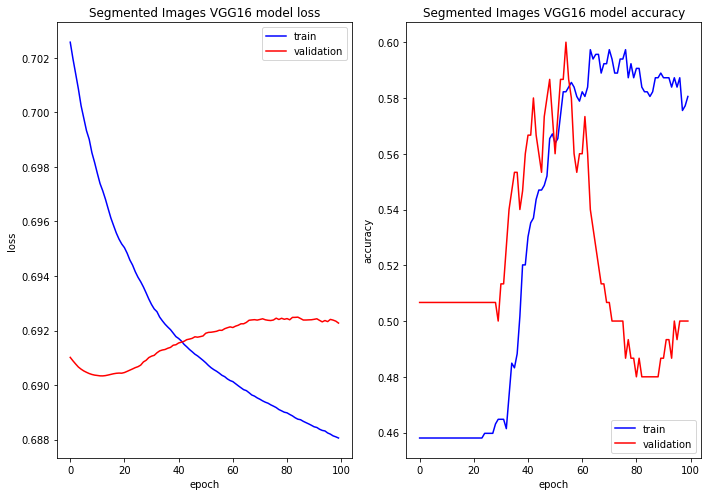

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('Segmented Images VGG16 model loss')
ax[0].plot(history_vgg_seg.history['loss'], 'b')
ax[0].plot(history_vgg_seg.history['val_loss'], 'r')
ax[0].legend(['train', 'validation'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('Segmented Images VGG16 model accuracy')
ax[1].plot(history_vgg_seg.history['accuracy'], 'b')
ax[1].plot(history_vgg_seg.history['val_accuracy'], 'r')
ax[1].legend(['train', 'validation'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

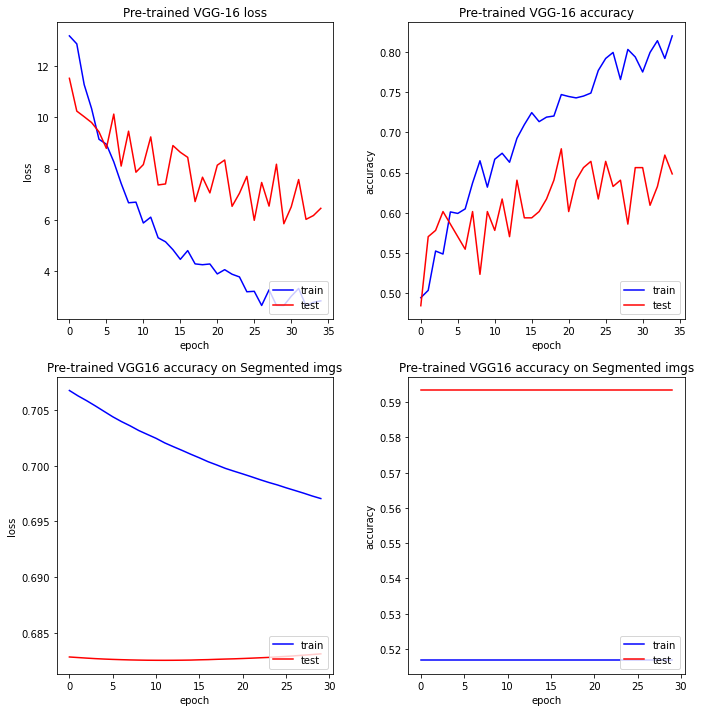

In [ ]:
# evaluate model
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# loss
ax[0,0].set_title('Pre-trained VGG-16 loss')
ax[0,0].plot(history_vgg_pretrained.history['loss'], 'b')
ax[0,0].plot(history_vgg_pretrained.history['val_loss'], 'r')
ax[0,0].legend(['train', 'validation'], loc='lower right')
ax[0,0].set_ylabel('loss')
ax[0,0].set_xlabel('epoch')
ax[1,0].set_title('Pre-trained VGG16 accuracy on Segmented imgs')
ax[1,0].plot(history_vgg_seg.history['loss'], 'b')
ax[1,0].plot(history_vgg_seg.history['val_loss'], 'r')
ax[1,0].legend(['train', 'validation'], loc='lower right')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xlabel('epoch')



# accuracy 
ax[0,1].set_title('Pre-trained VGG-16 accuracy')
ax[0,1].plot(history_vgg_pretrained.history['accuracy'], 'b')
ax[0,1].plot(history_vgg_pretrained.history['val_accuracy'], 'r')
ax[0,1].legend(['train', 'validation'], loc='lower right')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('epoch')
ax[1,1].set_title('Pre-trained VGG16 accuracy on Segmented imgs')
ax[1,1].plot(history_vgg_seg.history['accuracy'], 'b')
ax[1,1].plot(history_vgg_seg.history['val_accuracy'], 'r')
ax[1,1].legend(['train', 'validation'], loc='lower right')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_xlabel('epoch')


plt.tight_layout()
plt.show()

## Pretrained ResNet50 

In [ ]:
from keras.applications import ResNet50

In [ ]:
base_ResNet = ResNet50(input_shape=(248, 248,3), include_top=False, weights="imagenet")

for layer in base_ResNet.layers:
    layer.trainable = False

base_ResNet = Sequential()
base_ResNet.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_ResNet.add(Dense(1, activation='sigmoid'))

base_ResNet.compile(tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.AUC(
        num_thresholds=200, curve='ROC',summation_method='interpolation', name=None, dtype=None,
        thresholds=None, multi_label=False, label_weights=None),'accuracy'])

base_ResNet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
history_ResNet = base_ResNet.fit(train_generator_pretrained, steps_per_epoch = train_generator_pretrained.samples // batch,
        validation_data = validation_generator_pretrained, validation_steps = validation_generator_pretrained.samples // batch,
        epochs=30)

Epoch 1/100
9/9 [==============================] - 26s 2s/step - loss: 2.3483 - accuracy: 0.5294 - recall: 0.6871 - precision: 0.5405 - val_loss: 2.1472 - val_accuracy: 0.5703 - val_recall: 0.3284 - val_precision: 0.6875
Epoch 2/100
9/9 [==============================] - 15s 2s/step - loss: 1.7937 - accuracy: 0.5644 - recall: 0.5678 - precision: 0.6055 - val_loss: 2.2003 - val_accuracy: 0.5391 - val_recall: 0.3571 - val_precision: 0.6410
Epoch 3/100
9/9 [==============================] - 15s 2s/step - loss: 1.9543 - accuracy: 0.5311 - recall: 0.5284 - precision: 0.5595 - val_loss: 1.9025 - val_accuracy: 0.5547 - val_recall: 0.3676 - val_precision: 0.6410
Epoch 4/100
9/9 [==============================] - 15s 2s/step - loss: 1.4128 - accuracy: 0.6150 - recall: 0.6318 - precision: 0.6618 - val_loss: 2.0702 - val_accuracy: 0.5156 - val_recall: 0.3731 - val_precision: 0.5556
Epoch 5/100
9/9 [==============================] - 15s 2s/step - loss: 1.4382 - accuracy: 0.6391 - recall: 0.6430 - 

In [ ]:
base_ResNet.evaluate_generator(validation_generator_pretrained, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3/3 [==============================] - 5s 1s/step - loss: 1.1361 - recall_8: 0.8780 - precision_8: 0.6959 - auc_8: 0.8139 - accuracy: 0.7363


[1.0471510887145996,
 0.8860759735107422,
 0.7142857313156128,
 0.8256283402442932,
 0.75]

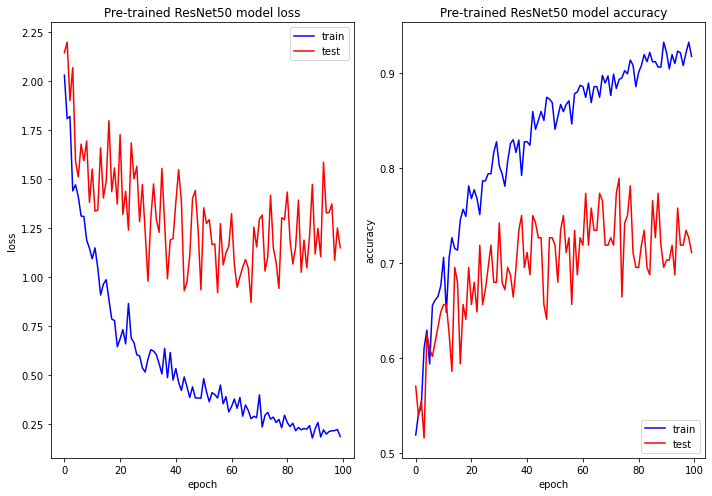

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('Pre-trained ResNet50 model loss')
ax[0].plot(history_ResNet.history['loss'], 'b')
ax[0].plot(history_ResNet.history['val_loss'], 'r')
ax[0].legend(['train', 'validation'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('Pre-trained ResNet50 model accuracy')
ax[1].plot(history_ResNet.history['accuracy'], 'b')
ax[1].plot(history_ResNet.history['val_accuracy'], 'r')
ax[1].legend(['train', 'validation'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

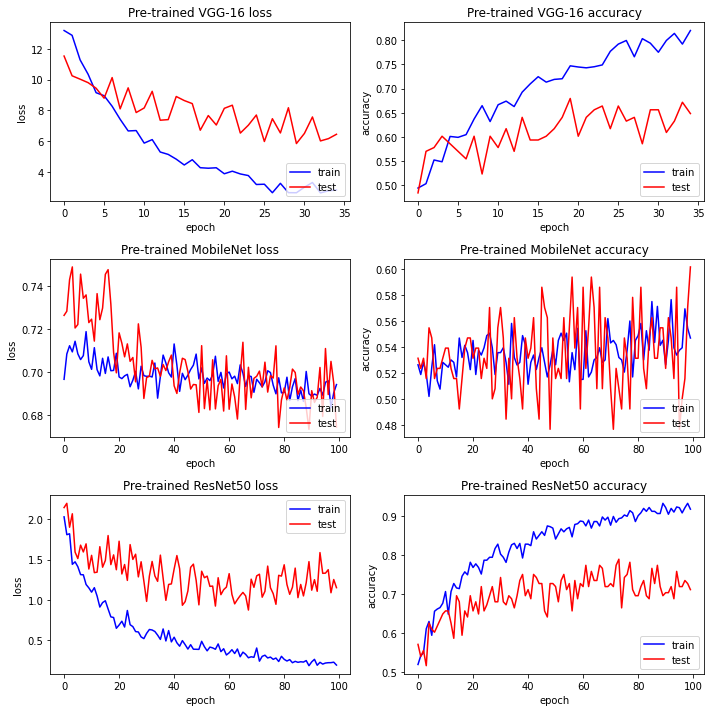

In [ ]:
# evaluate model
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# loss
ax[0,0].set_title('Pre-trained VGG-16 loss')
ax[0,0].plot(history_vgg_pretrained.history['loss'], 'b')
ax[0,0].plot(history_vgg_pretrained.history['val_loss'], 'r')
ax[0,0].legend(['train', 'validation'], loc='lower right')
ax[0,0].set_ylabel('loss')
ax[0,0].set_xlabel('epoch')
ax[1,0].set_title('Pre-trained MobileNet loss')
ax[1,0].plot(history_mobileNet_pretrained.history['loss'], 'b')
ax[1,0].plot(history_mobileNet_pretrained.history['val_loss'], 'r')
ax[1,0].legend(['train', 'validation'], loc='lower right')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xlabel('epoch')
ax[2,0].set_title('Pre-trained ResNet50 loss')
ax[2,0].plot(history_ResNet.history['loss'], 'b')
ax[2,0].plot(history_ResNet.history['val_loss'], 'r')
ax[2,0].legend(['train', 'validation'], loc='upper right')
ax[2,0].set_ylabel('loss')
ax[2,0].set_xlabel('epoch')



# accuracy 
ax[0,1].set_title('Pre-trained VGG-16 accuracy')
ax[0,1].plot(history_vgg_pretrained.history['accuracy'], 'b')
ax[0,1].plot(history_vgg_pretrained.history['val_accuracy'], 'r')
ax[0,1].legend(['train', 'validation'], loc='lower right')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('epoch')
ax[1,1].set_title('Pre-trained MobileNet accuracy')
ax[1,1].plot(history_mobileNet_pretrained.history['accuracy'], 'b')
ax[1,1].plot(history_mobileNet_pretrained.history['val_accuracy'], 'r')
ax[1,1].legend(['train', 'validation'], loc='lower right')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_xlabel('epoch')
ax[2,1].set_title('Pre-trained ResNet50 accuracy')
ax[2,1].plot(history_ResNet.history['accuracy'], 'b')
ax[2,1].plot(history_ResNet.history['val_accuracy'], 'r')
ax[2,1].legend(['train', 'validation'], loc='lower right')
ax[2,1].set_ylabel('accuracy')
ax[2,1].set_xlabel('epoch')

plt.tight_layout()
plt.show()